[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  1.15384615e+10  0.00000000e+00
   1.92307692e+09  9.61538462e+08 -5.76923077e+09  4.80769231e+09]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  1.92307692e+09  0.00000000e+00
   1.15384615e+10  4.80769231e+09 -7.69230769e+09  9.61538462e+08]
 [ 0.00000000e+00  0.00000000e+00  9.61538462e+08  0.00000000e+00
   4.80769231e+09  1.15384615e+10 -9.61538462e+08  1.92307692e+09]
 [ 0.00000000e+00  0.00000000e+00 -5.76923077e+09  0.00000000e+00
  -7.69230769e+09 -9.61538462e+08  1.15384615e+10 -4.80769231e+09]
 [ 0.00000000e+00  0.00000000e+00  4.80769231e+09  0.00000000e+00
   

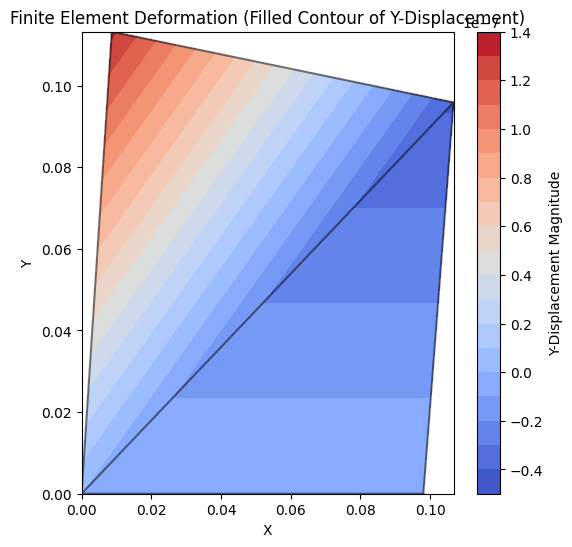

In [20]:
import numpy as np

gauss_points = np.array([[-0.577350269, -0.577350269],
                         [ 0.577350269, -0.577350269],
                         [ 0.577350269,  0.577350269],
                         [-0.577350269,  0.577350269]])
gauss_weights = np.array([1, 1, 1, 1])

def shape_functions(xi, eta):
    dNdX_ = np.zeros((2, 4))
    N = np.array([(1-xi)*(1-eta)/4,
                  (1+xi)*(1-eta)/4,
                  (1+xi)*(1+eta)/4,
                  (1-xi)*(1+eta)/4])
    dNdX_[0,:] = np.array([-(1-eta)/4, (1-eta)/4, (1+eta)/4, -(1+eta)/4])
    dNdX_[1,:] = np.array([-(1-xi)/4, -(1+xi)/4, (1+xi)/4, (1-xi)/4])
    return N, dNdX_

def compute_stiffness_matrix(node_coords, elasticity_matrix, thickness):
    m_dim = 2  # 2D problem
    m_nodxelem = 4  # Quadrilateral element
    
    K = np.zeros((m_nodxelem * m_dim, m_nodxelem * m_dim))
    
    for gp in range(4):
        xi, eta = gauss_points[gp]
        N, dNdrs = shape_functions(xi, eta)
        
        J = np.dot(dNdrs, node_coords)
        detJ = np.linalg.det(J)
        invJ = np.linalg.inv(J)

        dNdX = np.dot(invJ, dNdrs)
        
        B = np.zeros((3, m_nodxelem * m_dim))
        for i in range(m_nodxelem):
            B[0, i*2]   = dNdX[0, i]
            B[1, i*2+1] = dNdX[1, i]
            B[2, i*2]   = dNdX[1, i]
            B[2, i*2+1] = dNdX[0, i]
        
        K += B.T @ elasticity_matrix @ B * detJ * gauss_weights[gp] * thickness
        #Equivalent to. K += np.matmul(np.matmul(B.T, elasticity_matrix), B) * detJ * gauss_weights[gp] * thickness
        # OR: K += np.dot(np.dot(B.T, elasticity_matrix), B) * detJ * gauss_weights[gp] * thickness
        # B.T @ elasticity_matrix → Multiplies the transposed strain-displacement matrix (B.T) with the elasticity matrix.
    return K

def apply_boundary_condition(K, dof):
    """
    Apply a boundary condition to the stiffness matrix by modifying a specific degree of freedom (dof).
    """
    K[dof, :] = 0
    K[:, dof] = 0
    K[dof, dof] = 1
    
    return K

def elasticity_matrix_plane_strain(E, nu):
    """
    Compute the elasticity matrix for plane strain condition.
    """
    factor = E / ((1 + nu) * (1 - 2 * nu))
    C = factor * np.array([[1 - nu, nu, 0],
                            [nu, 1 - nu, 0],
                            [0, 0, (1 - 2 * nu) / 2]])
    return C

# The elasticity matrix for plane stress differs:
# C_plane_stress = (E / (1 - nu**2)) * np.array([[1, nu, 0],
#                                                 [nu, 1, 0],
#                                                 [0, 0, (1 - nu) / 2]])

# Plane strain elasticity matrix is 3x3, considering strain in z-direction as zero.
# Plane stress elasticity matrix is also 3x3 but assumes zero stress in z-direction.

def solve_displacement(K, F):
    """
    Solve the linear system K * X = F for the displacement vector X.
    """
    X = np.linalg.solve(K, F)
    return X

import matplotlib.pyplot as plt

def plot_deformation(node_coords, displacements, scale=1e5):
    deformed_coords = node_coords + displacements.reshape(-1, 2) * scale
    plt.figure(figsize=(6,6))
    
    # Plot original shape
    plt.plot(*zip(*node_coords, node_coords[0]), 'bo-', label='Original')
    # Plot deformed shape
    plt.plot(*zip(*deformed_coords, deformed_coords[0]), 'ro-', label='Deformed')
    
    plt.legend()
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.title("Finite Element Deformation")
    plt.show()

import matplotlib.tri as tri

def plot_deformation_filled(node_coords, displacements, scale=100):
    deformed_coords = node_coords + displacements.reshape(-1, 2) * scale
    
    plt.figure(figsize=(6, 6))

    # Extract X and Y coordinates of deformed nodes
    x_deformed = deformed_coords[:, 0]
    y_deformed = deformed_coords[:, 1]

    # Extract Y-displacements (color field)
    y_displacements = displacements[1::2]  # Every second element (corresponding to Y direction)

    # Define triangulation for filled contour
    triang = tri.Triangulation(x_deformed, y_deformed)
    
    # Plot filled contour
    contour = plt.tricontourf(triang, y_displacements, cmap='coolwarm', levels=20)
    plt.colorbar(contour, label="Y-Displacement Magnitude")

    # Overlay deformed mesh edges
    plt.triplot(triang, 'k-', alpha=0.5)

    # Label and show plot
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.title("Finite Element Deformation (Filled Contour of Y-Displacement)")
    plt.show()

    
# Example usage
node_coords = np.array([[0, 0], [0.1, 0], [0.1, 0.1], [0, 0.1]])
E, nu = 200e9, 0.3  # Example values for steel
elasticity_matrix = elasticity_matrix_plane_strain(E, nu)
thickness = 0.1
K = compute_stiffness_matrix(node_coords, elasticity_matrix, thickness)

apply_boundary_condition(K,0)
apply_boundary_condition(K,1)
apply_boundary_condition(K,3)
print(K)

F = np.zeros(K.shape[0])
F[-1] = 1000  # Apply force at last node in x-direction

print(F)
# Solve for displacements
print("Displacements")
X = solve_displacement(K, F)
print(X)


#plot_deformation(node_coords, X)
plot_deformation_filled(node_coords, X,1e5)
